In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#import dill as pickle
#import requests
#import json
#import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
train = pd.read_csv("D:\Рабочий стол\Мэг_питон\ML\База данных\heart_adapt_train.csv")
train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [3]:
test = pd.read_csv("D:\Рабочий стол\Мэг_питон\ML\База данных\heart_adapt_test.csv")
test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,44.0,M,NAP,130.0,233.0,0,Normal,179,Y,0.4,Up,0
1,63.0,M,ASY,130.0,308.0,0,Normal,138,Y,2.0,Flat,1
2,35.0,F,TA,120.0,160.0,0,ST,185,N,0.0,Up,0
3,69.0,M,NAP,140.0,NaN,1,ST,118,N,2.5,Down,1
4,NaN,M,TA,142.0,200.0,1,ST,100,N,1.5,Down,1


In [4]:
train.info() # есть пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [5]:
train.isna().sum()

Age                56
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       127
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [6]:
train.select_dtypes(include='object').apply(lambda x: x.unique())

Sex                            [M, F]
ChestPainType     [NAP, ATA, ASY, TA]
RestingECG          [Normal, LVH, ST]
ExerciseAngina                 [N, Y]
ST_Slope             [Up, Flat, Down]
dtype: object

In [7]:
train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,533.000000,588.000000,462.000000,589.000000,589.000000,589.000000,589.000000
mean,54.195122,133.358844,245.632035,0.258065,134.893039,0.937521,0.646859
std,9.532661,18.851852,58.599184,0.437942,24.942596,1.071318,0.478352
min,28.000000,80.000000,85.000000,0.000000,63.000000,-2.600000,0.000000
25%,48.000000,120.000000,209.000000,0.000000,117.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,0.000000,135.000000,0.800000,1.000000
75%,61.000000,144.000000,279.750000,1.000000,154.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,195.000000,5.000000,1.000000


In [8]:
class Heart_Preprocessing(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns = X.columns.str.lower()
        X.dropna(axis='index', subset=['restingbp'], inplace=True)
        X.age.fillna(X.age.median()-0.5, inplace = True) 
        # заменяем значение на близкое медиане , но в отдельную группу     
        X['cholesterol'].fillna(X.groupby(['age',
        'sex'])['cholesterol'].transform('median'), inplace = True) 
        # заполняем по схожим группам, 2 наблюдения не вошло ни в одну
        X.cholesterol.fillna(X.cholesterol.median(), inplace = True)   
        return X

In [9]:
HP = Heart_Preprocessing()
HP.fit(train)
train_HP = HP.transform(train)
train_HP.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,74.0,M,NAP,138.0,310.0,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,54.5,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [10]:
train_HP.isna().sum()

age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64

In [11]:
train_HP['heartdisease'].value_counts() # наблюдается дисбаланс классов

heartdisease
1    380
0    208
Name: count, dtype: int64

<Axes: >

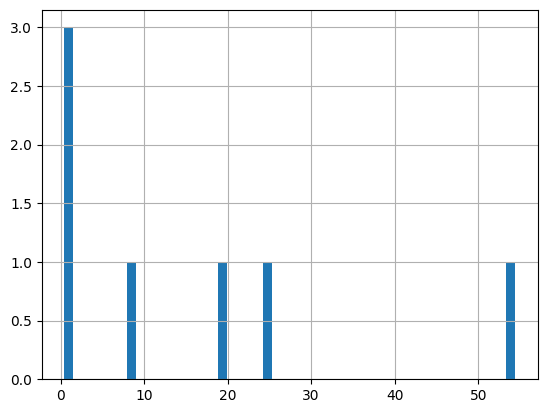

In [12]:
train_HP.describe().loc['std', :].hist(bins=50) # необходимость масштабирвания

In [13]:
target_train = train_HP['heartdisease']
features_train = train_HP.drop(['heartdisease'], axis=1)
target_test = test['HeartDisease']
features_test = test.drop(['HeartDisease'], axis=1)

Подготовим конвейнер для последовательного запуска всех трансформеров: 

In [14]:
num_features = features_train.select_dtypes(exclude  = 'object').columns
#['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak']
cat_features = features_train.select_dtypes(include = 'object').columns
#['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']

# поместим в ColumnTransformer
# позволяет применять разные преобразователи к разным столбцам
preprocessor = ColumnTransformer(
      transformers=[('scaler', StandardScaler(), num_features),
                    ('OHE', OneHotEncoder(), cat_features)])

pipe = Pipeline(steps = [('Heart_Preprocessing', Heart_Preprocessing()),
                         ('preprocessor', preprocessor),
                         ('classify', DecisionTreeClassifier(
                             class_weight='balanced', random_state=42))])

params = [
    {'classify': [LogisticRegression(solver='liblinear', 
                    class_weight='balanced', random_state=42)]}, 
    {'classify': [RandomForestClassifier(class_weight='balanced', 
                                         random_state=42)],
                   'classify__max_depth': [2, 5, 10, 20],
                   'classify__n_estimators': range (1, 21, 2),
                   'classify__min_samples_leaf': range(1, 10, 3),
                   'classify__min_samples_split': [3, 4, 6, 9]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced',
                                         random_state=42)],
      'classify__max_depth': [2, 5, 10, 20], 
      'classify__min_samples_leaf': range(1, 10, 3),
      'classify__min_samples_split': range(1, 10, 3)}
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=features_train, y=target_train)
print(
    'Качество модели на тестовой выборке c лучшей моделью:', 
    {roc_auc_score(target_test, grid_search.predict_proba(features_test)[:, 1])}
)

Качество модели на тестовой выборке c лучшей моделью: {0.9095613048368953}


c:\Users\Танюша\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 2585.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Танюша\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Танюша\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Танюша\

In [15]:
grid_search.best_estimator_

Pipeline(steps=[('Heart_Preprocessing', Heart_Preprocessing()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak'], dtype='object')),
                                                 ('OHE', OneHotEncoder(),
                                                  Index(['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope'], dtype='object'))])),
                ('classify',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=6, n_estimators=17,
                                        random_state=42))])

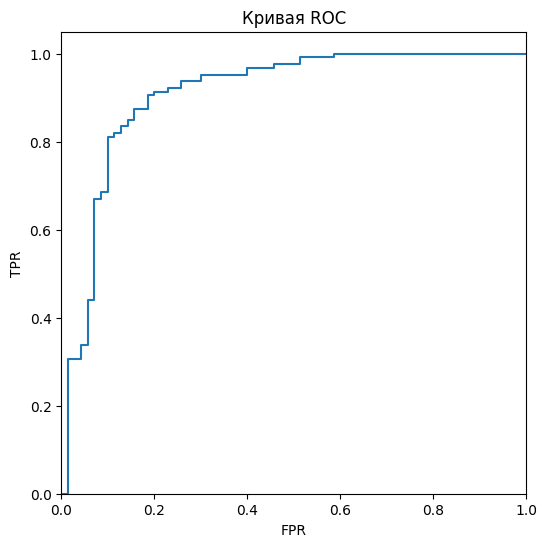

In [16]:
fpr, tpr, thresholds = roc_curve(target_test, grid_search.predict_proba(features_test)[:, 1])

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show() 

Shape?

In [17]:
df_onehot = train_HP.copy()
onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['sex',
            'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']]))
n = onehotencoder.get_feature_names_out()
encoded_df.columns = n
encoded_df

c:\Users\Танюша\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,sex_F,sex_M,chestpaintype_ASY,chestpaintype_ATA,chestpaintype_NAP,chestpaintype_TA,restingecg_LVH,restingecg_Normal,restingecg_ST,exerciseangina_N,exerciseangina_Y,st_slope_Down,st_slope_Flat,st_slope_Up
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
584,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
585,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
586,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [18]:
delayed_features_norm = pd.DataFrame(encoded_df, columns= n)

In [19]:
final_df = df_onehot.join(encoded_df)
final_df.drop(['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope'], axis= 1 , inplace= True )
final_df.columns = final_df.columns.astype(str)
final_df.dropna(inplace=True)

In [20]:
best_model = grid_search.best_estimator_
pred_test = best_model.predict(features_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


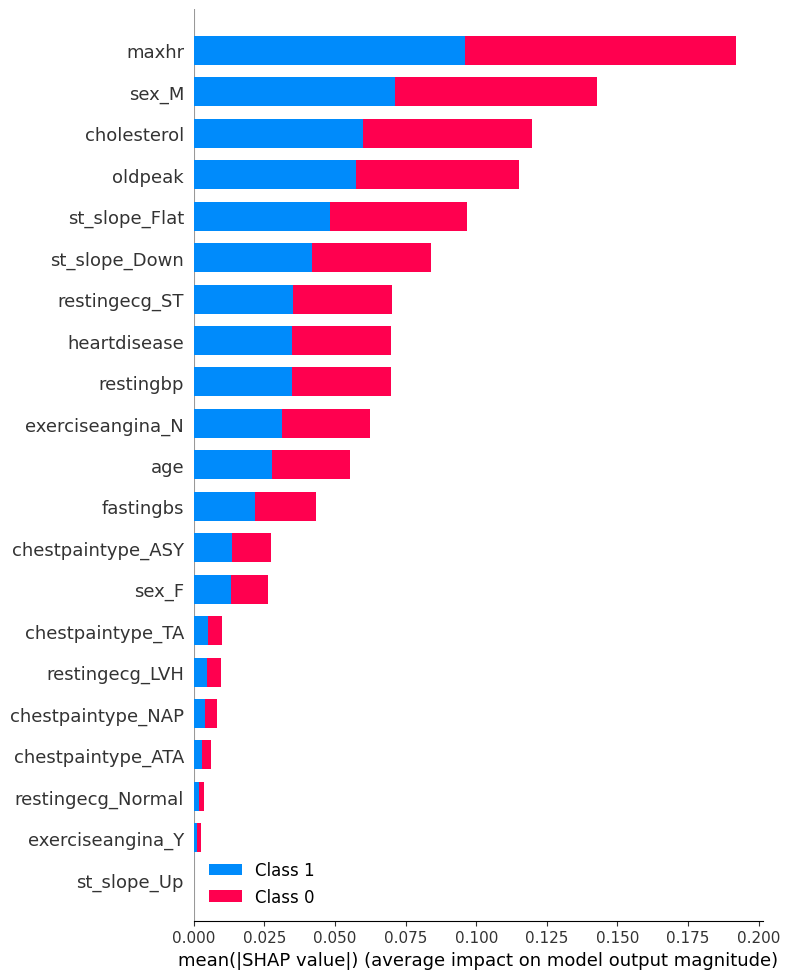

In [21]:
import shap
shap_test = shap.TreeExplainer(grid_search.best_estimator_['classify']).shap_values(final_df)
shap.summary_plot(shap_test, final_df, max_display=25) # plot_type = «bar».

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


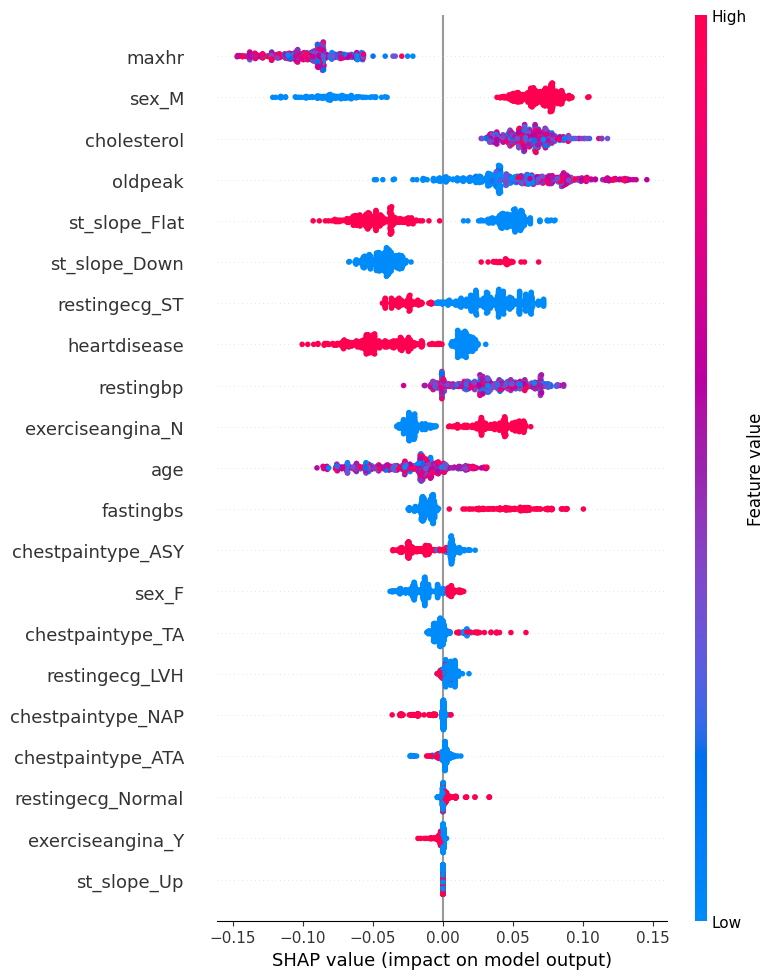

In [22]:
shap_test = shap.TreeExplainer(grid_search.best_estimator_['classify']).shap_values(final_df)
shap.summary_plot(shap_test[1], final_df, max_display=25, auto_size_plot=True)
# для веса признака: чем выше его значение, тем меньше значение SHAP

Самыми важными характеристиками в наборе данных оказались: достигнутая максимальная частота сердечных сокращений(MaxHR), мужской пол(sex_M) - тк их значительно меньше в выборке, уровень холестерина (Cholesterol),  подавление сегмента ST, вызванное упражнением (относительно отдыха) (oldpeak)  
Риск заболевыния увеличивается с повышением уровня сахара в крови натощак (FastingBS) и oldpeak. 

Исследование данных:

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'restingbp'}>,
        <Axes: title={'center': 'cholesterol'}>],
       [<Axes: title={'center': 'fastingbs'}>,
        <Axes: title={'center': 'maxhr'}>,
        <Axes: title={'center': 'oldpeak'}>],
       [<Axes: title={'center': 'heartdisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

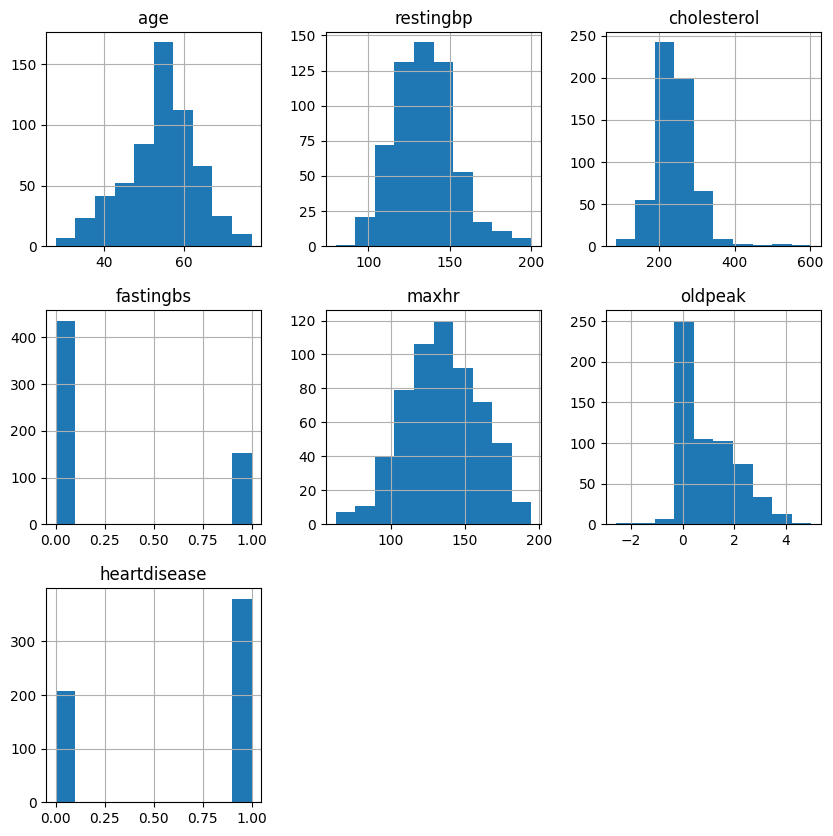

In [23]:
train_HP.hist(figsize=(10, 10))
# данные распределены неравномерно

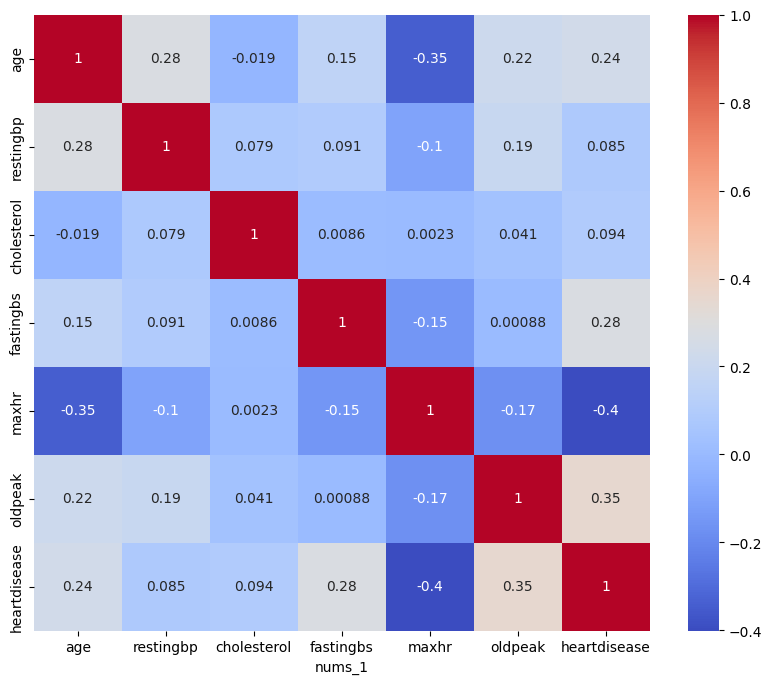

In [24]:
tmp = train_HP.select_dtypes(exclude='object').corr()
plt.figure(figsize=(10,8))
sns.heatmap(tmp, annot=True, cmap='coolwarm')
plt.imshow(tmp)
plt.xlabel('nums_1')
plt.show()

Сильно коррелирующие значения отсутствуют - мультиколлинеарность не наблюдается

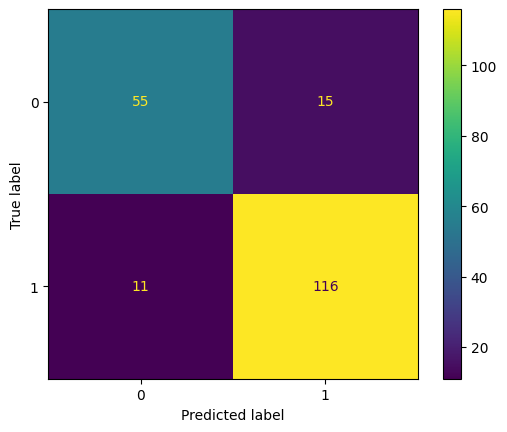

In [25]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_test), 
                       display_labels=['0', '1']).plot()
# визуализация матрицы ошибок - соответствует ожидаемому распределению

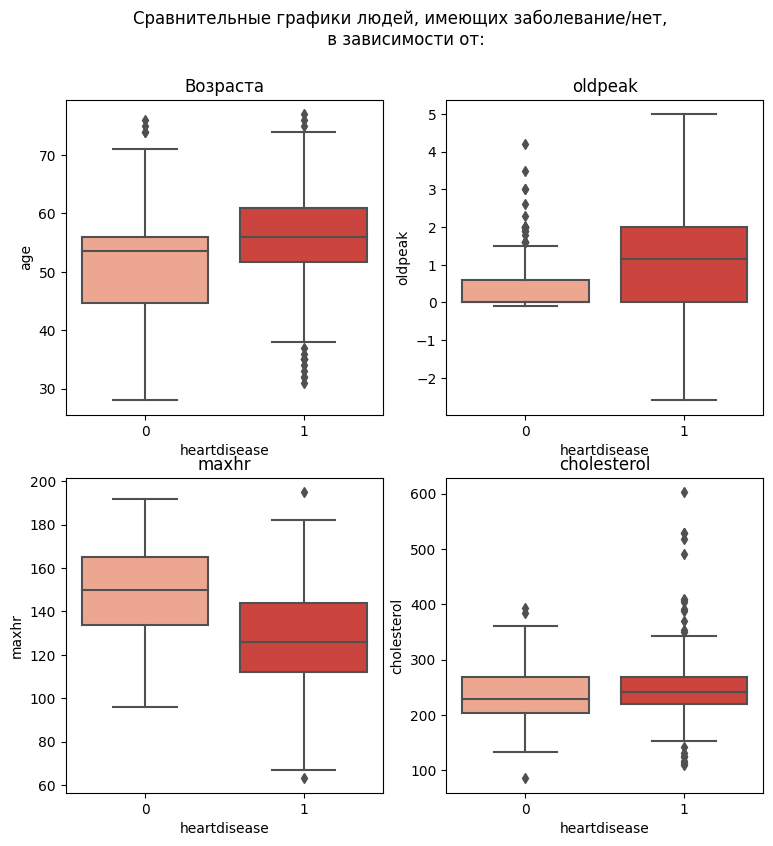

In [26]:
def plot_box(data, col, ax, name):
    sns.boxplot(data = data, x= 'heartdisease', y =  col, ax= ax, palette = 'Reds')
    ax.set_title(name)
    plt.show

fig, axes = plt.subplots(2, 2,  figsize=(9, 9))
fig.suptitle('Сравнительные графики людей, имеющих заболевание/нет, \n в зависимости от:')
plot_box(train_HP, 'age', axes[0,0], 'Возраста')
plot_box(train_HP, 'oldpeak', axes[0,1], 'oldpeak')
plot_box(train_HP, 'maxhr', axes[1,0], 'maxhr')
plot_box(train_HP, 'cholesterol', axes[1,1], 'cholesterol')

У нас есть выбросы в данных, у больных людей в среднем выше возраст(55-60 лет), oldpeak (подавление сегмента ST, вызванное упражнением) (медиана стабильно = 1), медиана MaxHR (максимально достигнутая частота сердечных сокращений) = 125 - вероятно в следствие ослабления сердечной мышцы (у здоровых людей = 150), также больше выбросов(до 600 включительно) и чуть выше медиана уровня холестерина.

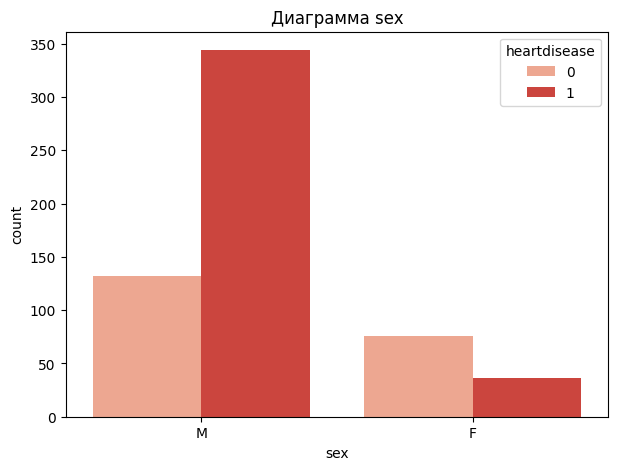

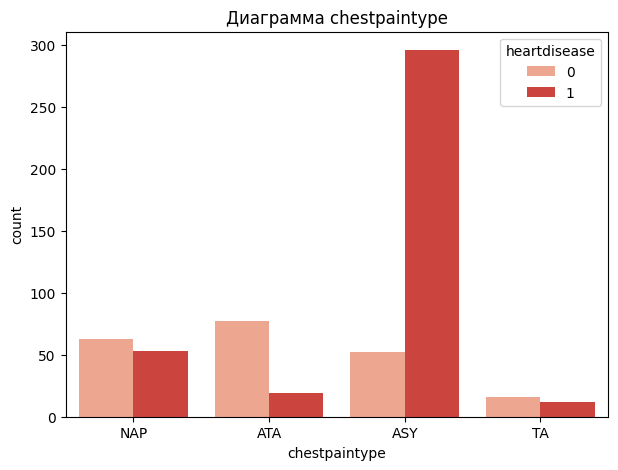

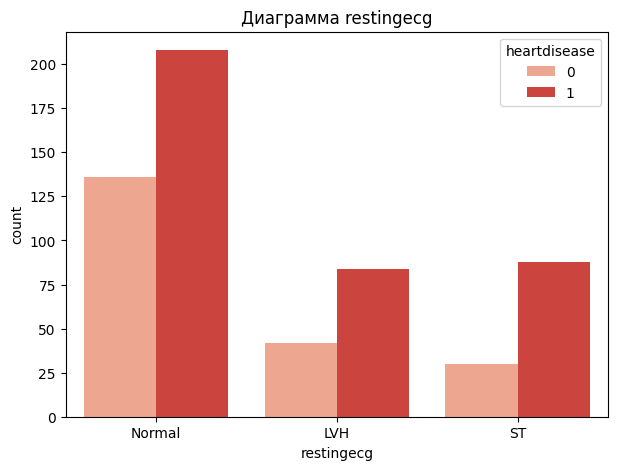

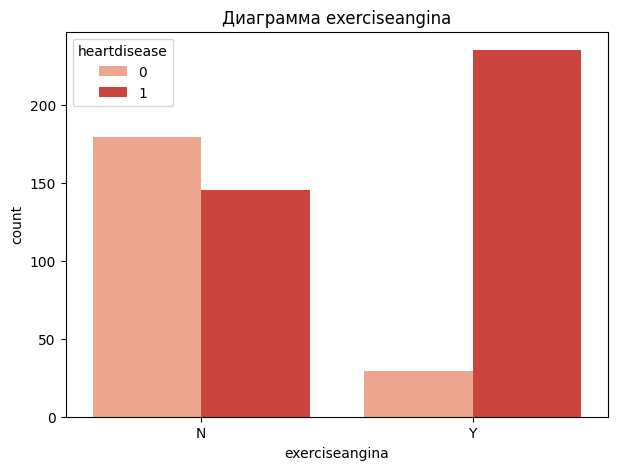

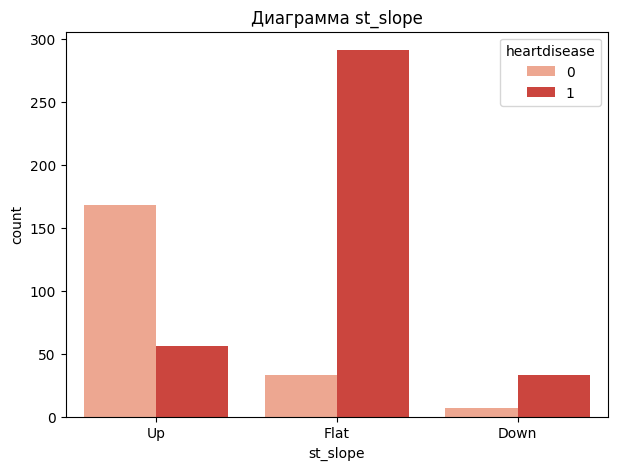

In [27]:
def plot_hist(data, col, figsize, name):
    plt.figure(figsize = figsize)
    plt.title(f'{name} {col}')
    sns.countplot(data=data, x = col, hue = 'heartdisease', palette = 'Reds')
    plt.show
for col in train_HP.select_dtypes(include='object'):
    plot_hist(train_HP, f'{col}', (7,5),'Диаграмма')

plt.show()

Сердечным заболеванием преимущественно страдают женщины, боли в груди - бессимптомны (у здоровых людей, как правило, атипичная стенокардия), стенокардия вызвается физической нагрузкой, наклон сегмента ST при максимальной нагрузке ровный (Flat)

Вывод: Наилучшая модель для предсказания заболевания (по roc_auc) - RandomForestClassifier (= 0.9095) с параметрами class_weight='balanced', max_depth=10, min_samples_split=6, n_estimators=17, random_state=42